### Types of Backtests

백테스트에는 Walk-Forward, Resampling, Monte Carlo Simulation으로 대개 세 가지 유형으로 구분된다

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = yf.download('SPY', start = '2020-01-01', progress = False)

#### The Walk Forward Backtest

역사적 백테스팅으로도 불리는 Walk Forward 방식은 전방 진행 방식으로, 과거의 일련의 사건과 자산 가격 움직임에 대해 전략을 평가하는 방식이다. 이 방식을 적용하는 것은 보기에는 비록 간단해 보이지만, 설정과 실행헤 있어서 부정확성은 편향된 결과를 초래할 수 있다.(예를 들면 거시경제 변수를 사용하는 경우 발표일을 잘못 기재하거나, 그 당시에 사용 불가능한 수정된 데이터를 사용하는 등의 문제가 있다) Walk Forward 방식은 잠재적인 함정이 모두 회피되는 경우에도 여전히 경로에 의존하며, 과거의 과정과 사건이 미래에 반복될 것이라고 가정한다. Walk Forward 방식의 가장 큰 장점은 결과와 수행 특성이 서로 다른 기간에 분석, 해석 및 비교하기 쉽다는 점이다. 또한, 다른 두 방식에서 요구하는 데이터 생성 과정이나 적절한 Resampling 기법을 실무자가 알고 있을 필요가 없다.

이 접근 방식의 주요 한계 중 하나는 단일 경로만 테스트되기 때문에, Overfitting의 위험이 높아진다는 것이다(Bailey and Lopez de Prado, 2014). 또 다른 단점은 전략이 활용하려는 기본 관계가 반복되지 않을 수 있기 때문에, 관찰된 과거의 백테스팅 성과가 미래의 결과를 보장하는 것은 아니다. 이는 전방 진행 방식이 정의상 실무자에게 젼략의 성공 또는 실패 이유에 대한 포괄적인 이해나 지식을 요구하지 않는다는 비판적인 관찰로 이어질 수 있다. 결과적으로, 실무자가 발견한 전략은 잘못된 가정에 근거한 것일 수 있으며, 거짓 전략일 확률이 높다.

In [2]:
data['SMA_5'] = data['Close'].rolling(window = 5).mean()
data['SMA_20'] = data['Close'].rolling(window = 20).mean()

In [3]:
data['Signal'] = 0
data.loc[data['SMA_5'] > data['SMA_20'], 'Signal'] = 1
data.loc[data['SMA_5'] < data['SMA_20'], 'Signal'] = -1

In [4]:
data['Position'] = data['Signal'].shift(1)

In [5]:
data['Strategy_Return'] = data['Position'] * data['Close'].pct_change()
data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()

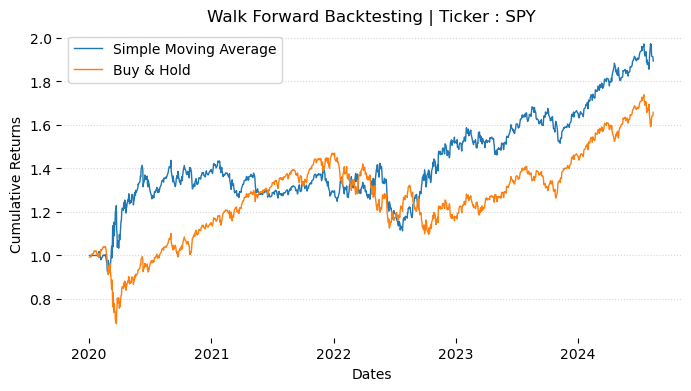

In [6]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(data['Cumulative_Strategy_Return'], lw = 1, label = 'Simple Moving Average')
ax.plot((1 + data['Close'].pct_change()).cumprod(), lw = 1, label = 'Buy & Hold')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Walk Forward Backtesting | Ticker : SPY')
plt.xlabel('Dates')
plt.ylabel('Cumulative Returns')
plt.show()

#### The Resampling Method

두 번째 유형의 백테스팅은 Resampling이라고 알려진 추론 통계 방법의 변형된 형태를 포함한다. 이 방법은 이름에서 알 수 있듯이, 과거 관측치를 Resampling(재표본추출) 하여 구성한다. 새로운 경로를 통해 Walk Forward의 접근 방식의  주요 단점을 극복할 수 있다. 이 방법에는 Cross Validation 및 Bootstrapping과 같은 기술이 포함된다. Cross Validation은 관찰을 그룹으로 나누고 훈련 및 검증 목적으로 Lopez de Prado(2018)가 자세히 설명한 Purged Cross Validation 및 Embargo process와 함께 K-fold 교차 검증을 포함하는 방법을 사용한다. 반면, Bootstrapping은 다양한 논리를 사용하여 샘플에서 관측치를 무작위로 도출하는 것을 의미하며, 이 중 여러 예는 Muscioto et al.(2018)에서 다룬다.

Out of sample 기간이 다른 다양한 path에 대한 백테스팅의 결과는 전략의 미래 성능을 나타낸다는 가정을 가지고 있다. 이러한 방법의 장점은 전략을 평가하고, 전략의 Robustness를 확인할 수 있는 여러 시간 경로를 사용할 수 있다는 것이다. 또한, 단일 지점이 아닌 일련의 성능 지표를 생성하여 전략을 보다 자세히 분석하고 비교할 수 있다. 마지막으로, Lopez de Prado(2018)은 Resampling 방법이 과적합될 가능성이 적다고 설명했다.

그럼에도 불구하고, Walk forward 방법에서 발생했던 특정 단점은 여전히 존재한다. 예를 들어, 여러 과거 경로에서 관찰된 성능이 미래를 정확하게 표현하지 못 할 수 있는데, 다시 말해서, 그 방식은 왜 전략이 성공적으로 작동하였는가에 대한 합리적인 이해를 요구하지 않는다. Resampling과 관련된 추가적인 단점은 전략이 사용하는 일부 기본 데이터가 Bootstrapping 접근 방식에 적합한 형식이 아닐 수도 있고, 데이터의 시간 의존석을 보존하기 위해 데이터를 더 긴 기간으로 분할해야 할 수도 있으며, 이로 인해 분할의 수와 관측치의 개수개 줄어들 수도 있다는 것이다.

#### Monte Carlo Simulation

세 번째 백테스팅 방법은 Monte Carlo Simulation으로, 이 방법을 구축하기 위한 데이터 생성 과정에 대한 이해가 필요하다. 이 지식은 이론적 구성과 전략이 활용하고자 하는 시계열 데이터 간의 인과 관계, 또는 통계 분석을 통해 얻을 수 있다.

기본적으로 이 방법은 Monte Carlo Simulation을 통해 미래 경로를 모델링할 수 있다는 것을 가정한다. 이 방법을 사용하면 실제 데이터에서 관찰된 것과 유사한 속성을 가진 추가 데이터를 생성할 수 있으므로 Resampling 방법에 비해 연구자가 분석할 수 있는 더 확실한 기본을 얻을 수 있다. Wises et al.(2020)과 Li et al.(2020)은 신경망을 사용한 데이터 생성 과정을 보여주며, 이는 이후 전략 백테스팅에 사용될 수 있다.

이 방법의 가장 큰 장점은 데이터 생성 과정이 변경되지 않고 정확하다면 추정된 성능이 실제로 미래의 결과로 이어진다는 것이다. 이 방법을 따르는 백테스트를 구성하려면 전략이 작동하는 이유를 이해하고, 다른 두 방법에 내재된 주요 한계 중 하나를 해결해야 한다. 또는 Monte Carlo Simulation을 사용하면 과적합의 위험이 완화된다.

또한 실제 트레이딩 상황에서 실제 데이터의 통계적 특성을 모니터링하고 시뮬레이션된 데이터 프로세스와 비교할 수 있으며, Structural Break을 감지하면 매매를 중단하고 손실을 방지하는 조기 경보 시스템으로 작동할 수 있다. 초기에 전략이 평가하기에 충분한 데이터가 없었던 상황에서 필요한 신뢰 수준에 도달하기 위해 추가적으로 데이터를 생성할 수도 있다.

이 방법이 직면한 가장 큰 과제는 전략에 사용되는 모든 데이터 소스에 대한 정확한 데이터 생성 프로세스를 구축하는 것이다. 2008년 금융위기나 COVID19 팬데믹과 같은 특별한 사건의 역사적 사건을 복제하는 것은 어려울 수 있지만, 이전에 나타난 적이 없던 새로운 시나리오를 포함한 다양한 데이터 프로세스를 만들 수 있다.